In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from Bio import SeqUtils
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load our data
train_sequences = pd.read_csv('../data/train_sequences.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

print("Data loaded successfully!")
print(f"Number of sequences: {len(train_sequences)}")
print(f"Number of coordinate points: {len(train_labels)}")

Data loaded successfully!
Number of sequences: 844
Number of coordinate points: 137095


In [4]:
class RNAFeatureExtractor:
    def __init__(self):
        """Initialize the feature extractor"""
        self.scaler = StandardScaler()
        
    def extract_basic_features(self, sequence):
        """Extract basic sequence features"""
        return {
            'length': len(sequence),
            'gc_content': (sequence.count('G') + sequence.count('C')) / len(sequence),
            'au_content': (sequence.count('A') + sequence.count('U')) / len(sequence),
            'g_content': sequence.count('G') / len(sequence),
            'c_content': sequence.count('C') / len(sequence),
            'a_content': sequence.count('A') / len(sequence),
            'u_content': sequence.count('U') / len(sequence)
        }
    
    def extract_local_structure_features(self, sequence, window_size=3):
        """Extract features related to local structure potential"""
        features = {}
        
        # Sliding window analysis
        for i in range(len(sequence) - window_size + 1):
            window = sequence[i:i+window_size]
            features[f'window_{i}_gc'] = (window.count('G') + window.count('C')) / window_size
            
        # Count potential base pairs
        features['gc_pairs'] = min(sequence.count('G'), sequence.count('C'))
        features['au_pairs'] = min(sequence.count('A'), sequence.count('U'))
        
        return features
    
    def extract_position_features(self, sequence):
        """Extract position-based features"""
        features = {}
        
        # Terminal nucleotides
        features['start_base'] = ord(sequence[0]) - ord('A')  # Numeric encoding
        features['end_base'] = ord(sequence[-1]) - ord('A')
        
        # Position-specific composition
        for pos in [0.25, 0.5, 0.75]:  # Relative positions
            idx = int(len(sequence) * pos)
            features[f'base_at_{pos}'] = ord(sequence[idx]) - ord('A')
            
        return features
    
    def extract_all_features(self, sequence):
        """Combine all feature extraction methods"""
        features = {}
        
        # Combine all feature types
        features.update(self.extract_basic_features(sequence))
        features.update(self.extract_local_structure_features(sequence))
        features.update(self.extract_position_features(sequence))
        
        return features

def create_feature_matrix(sequences):
    """Convert sequences to feature matrix"""
    extractor = RNAFeatureExtractor()
    features_list = []
    
    for seq in tqdm(sequences):
        features = extractor.extract_all_features(seq)
        features_list.append(features)
    
    return pd.DataFrame(features_list)

# Now let's test it
test_sequences = train_sequences['sequence'].head(3)
print("Testing feature extraction on 3 sequences:")
for i, seq in enumerate(test_sequences):
    print(f"\nSequence {i+1}:")
    print(f"Raw sequence: {seq}")
    print(f"Length: {len(seq)}")

feature_matrix = create_feature_matrix(test_sequences)

print("\n=== Feature Matrix Overview ===")
print(f"Shape: {feature_matrix.shape}")

print("\n1. Basic Sequence Features:")
basic_features = ['length', 'gc_content', 'au_content', 'g_content', 'c_content', 'a_content', 'u_content']
print(feature_matrix[basic_features].round(3))

print("\n2. Local Structure Features (first few):")
local_features = [col for col in feature_matrix.columns if 'window_' in col]
print(feature_matrix[local_features[:5]].round(3))

print("\n3. Position Features:")
pos_features = ['start_base', 'end_base'] + [col for col in feature_matrix.columns if 'base_at_' in col]
print(feature_matrix[pos_features].round(3))

# Calculate correlations between basic features
print("\n=== Feature Correlations ===")
correlation_matrix = feature_matrix[basic_features].corr()
print(correlation_matrix.round(3))

Testing feature extraction on 3 sequences:

Sequence 1:
Raw sequence: GGGUGCUCAGUACGAGAGGAACCGCACCC
Length: 29

Sequence 2:
Raw sequence: GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU
Length: 34

Sequence 3:
Raw sequence: GGGACUGACGAUCACGCAGUCUAU
Length: 24


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


=== Feature Matrix Overview ===
Shape: (3, 46)

1. Basic Sequence Features:
   length  gc_content  au_content  g_content  c_content  a_content  u_content
0      29       0.655       0.345      0.345      0.310      0.241      0.103
1      34       0.647       0.353      0.324      0.324      0.235      0.118
2      24       0.542       0.458      0.292      0.250      0.250      0.208

2. Local Structure Features (first few):
   window_0_gc  window_1_gc  window_2_gc  window_3_gc  window_4_gc
0          1.0        0.667        0.667        0.667        0.667
1          1.0        1.000        1.000        0.667        0.667
2          1.0        0.667        0.667        0.333        0.667

3. Position Features:
   start_base  end_base  base_at_0.25  base_at_0.5  base_at_0.75
0           6         2             2            0             2
1           6        20             6            2             0
2           6        20             6            2             6

=== Feature Corre

### findings: 

**current feature analysis:**
  - we have 46 total features (shape: (3, 46))  
  - strong correlations between composition features (as expected)  
  - good coverage of local structure through sliding windows  
  - basic position encoding  

**key findings:**
  - GC content ranges from 54.2% to 65.5%, matching our EDA patterns  
  - local structure windows show interesting patterns (high GC regions)  
  - position features capture terminal and quarter-point bases  


In [6]:
class EnhancedRNAFeatureExtractor:
    def __init__(self):
        self.scaler = StandardScaler()
        # Known RNA motifs from our EDA
        self.known_motifs = ['GGG', 'CCC', 'GGAC', 'GAAA', 'UUCG']
        
    def extract_basic_features(self, sequence):
        """Enhanced basic features"""
        length = len(sequence)
        return {
            'length': length,
            'gc_content': (sequence.count('G') + sequence.count('C')) / length,
            'au_content': (sequence.count('A') + sequence.count('U')) / length,
            'purine_content': (sequence.count('G') + sequence.count('A')) / length,
            'pyrimidine_content': (sequence.count('C') + sequence.count('U')) / length,
            'gc_ratio': sequence.count('G') / (sequence.count('C') + 1e-6),  # Avoid div by 0
            'au_ratio': sequence.count('A') / (sequence.count('U') + 1e-6)
        }
    
    def extract_structural_features(self, sequence):
        """Features related to potential structural elements"""
        features = {}
        
        # Potential stem regions (complementary base pairs)
        features['gc_stem_potential'] = min(sequence.count('G'), sequence.count('C'))
        features['au_stem_potential'] = min(sequence.count('A'), sequence.count('U'))
        
        # Look for palindromic sequences (potential hairpins)
        for i in range(3, 7):  # Look for palindromes of different lengths
            palindrome_count = 0
            for j in range(len(sequence)-i):
                seq = sequence[j:j+i]
                rev_comp = seq.replace('A','u').replace('U','a').replace('G','c').replace('C','g').upper()
                if seq == rev_comp[::-1]:
                    palindrome_count += 1
            features[f'palindrome_{i}'] = palindrome_count
            
        return features
    
    def extract_motif_features(self, sequence):
        """Extract features based on known RNA motifs"""
        features = {}
        
        # Count known motifs
        for motif in self.known_motifs:
            count = 0
            for i in range(len(sequence)-len(motif)+1):
                if sequence[i:i+len(motif)] == motif:
                    count += 1
            features[f'motif_{motif}'] = count
            
        # Homopolymer runs
        for base in 'AGCU':
            max_run = 0
            current_run = 0
            for b in sequence:
                if b == base:
                    current_run += 1
                    max_run = max(max_run, current_run)
                else:
                    current_run = 0
            features[f'max_{base}_run'] = max_run
            
        return features
    
    def extract_positional_features(self, sequence):
        """Enhanced position-based features"""
        length = len(sequence)
        features = {}
        
        # Terminal regions
        features['start_dinuc'] = sequence[:2]
        features['end_dinuc'] = sequence[-2:]
        
        # Segment composition
        segments = 4
        for i in range(segments):
            start = (length * i) // segments
            end = (length * (i+1)) // segments
            segment = sequence[start:end]
            features[f'segment_{i}_gc'] = (segment.count('G') + segment.count('C')) / len(segment)
            
        return features
    
    def extract_all_features(self, sequence):
        """Combine all feature extraction methods"""
        features = {}
        features.update(self.extract_basic_features(sequence))
        features.update(self.extract_structural_features(sequence))
        features.update(self.extract_motif_features(sequence))
        features.update(self.extract_positional_features(sequence))
        return features

# Test the enhanced feature extractor
def create_enhanced_feature_matrix(sequences):
    extractor = EnhancedRNAFeatureExtractor()
    features_list = []
    
    for seq in tqdm(sequences):
        features = extractor.extract_all_features(seq)
        features_list.append(features)
    
    return pd.DataFrame(features_list)

# Test on our sequences
test_sequences = train_sequences['sequence'].head(3)
enhanced_features = create_enhanced_feature_matrix(test_sequences)

print("\n=== Enhanced Feature Matrix Overview ===")
print(f"Shape: {enhanced_features.shape}")

# Display feature categories
feature_categories = {
    'Basic Features': ['length', 'gc_content', 'au_content', 'purine_content', 'pyrimidine_content'],
    'Structural Features': [col for col in enhanced_features.columns if 'stem' in col or 'palindrome' in col],
    'Motif Features': [col for col in enhanced_features.columns if 'motif_' in col or 'max_' in col],
    'Positional Features': [col for col in enhanced_features.columns if 'segment_' in col]
}

for category, features in feature_categories.items():
    print(f"\n{category}:")
    print(enhanced_features[features].round(3))

100%|██████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2993.08it/s]


=== Enhanced Feature Matrix Overview ===
Shape: (3, 28)

Basic Features:
   length  gc_content  au_content  purine_content  pyrimidine_content
0      29       0.655       0.345           0.586               0.414
1      34       0.647       0.353           0.559               0.441
2      24       0.542       0.458           0.542               0.458

Structural Features:
   gc_stem_potential  au_stem_potential  palindrome_3  palindrome_4  \
0                  9                  3             0             1   
1                 11                  4             0             4   
2                  6                  5             0             1   

   palindrome_5  palindrome_6  
0             0             0  
1             0             1  
2             0             0  

Motif Features:
   motif_GGG  motif_CCC  motif_GGAC  motif_GAAA  motif_UUCG  max_A_run  \
0          1          1           0           0           0          2   
1          1          1           0           

### findings cont'd:

**basic features show:**
  - GC content ranges from 54.2% to 65.5%  
  - purine content (G+A) is consistently high (54–59%)  
  - all sequences maintain roughly a 60:40 ratio between purines and pyrimidines  

**structural features reveal:**
  - sequence 2 (34 nt) has the most potential base pairs (11 GC pairs, 4 AU pairs)  
  - palindromes are rare but present (sequence 2 has most, including a 6-mer)  
  - all sequences have good stem-forming potential (high GC_stem_potential)  

**motif analysis shows:**
  - all sequences start with GGG (motif_GGG = 1)  
  - sequences 1 and 2 have CCC motifs  
  - sequence 2 has a longer A-run (max_A_run = 4)  
  - consistent G-runs of length 3 across all sequences  

**positional features indicate:**
  - higher GC content in terminal segments (segment_0_gc and segment_3_gc)  
  - variable GC distribution across middle segments  
  - sequence 1 has particularly high terminal GC content (0.875 in segment_3)  


### updated dynamic points of interest: 

- identify potential stem-loop structures  
- quantify base-stacking potential  
- find regions likely to form loops  


In [7]:
class StructuralFeatureAnalyzer:
    def __init__(self):
        # Watson-Crick base pairs
        self.pair_rules = {
            'G': 'C', 'C': 'G',
            'A': 'U', 'U': 'A'
        }
    
    def analyze_sequence(self, sequence):
        """Analyze structural potential in detail"""
        length = len(sequence)
        
        # Initialize features dictionary
        features = {
            'stem_probability': 0,
            'loop_regions': [],
            'stacking_energy': 0
        }
        
        # Calculate stem probability based on complementary bases
        for i in range(length):
            for j in range(i + 4, length):  # Minimum loop size of 3
                if self.pair_rules[sequence[i]] == sequence[j]:
                    features['stem_probability'] += 1
        
        features['stem_probability'] /= (length * (length - 1) / 2)  # Normalize
        
        # Identify potential loop regions (runs of unpaired bases)
        current_run = 0
        for i in range(length-3):
            window = sequence[i:i+4]
            # Check if window could form a loop (no strong base pairs)
            if window.count('G') + window.count('C') <= 1:
                current_run += 1
            else:
                if current_run >= 3:
                    features['loop_regions'].append((i-current_run, i))
                current_run = 0
        
        # Calculate stacking energy (simplified model)
        stacking_score = 0
        for i in range(length-1):
            if sequence[i:i+2] in ['GC', 'CG']:
                stacking_score += 3
            elif sequence[i:i+2] in ['AU', 'UA']:
                stacking_score += 2
        features['stacking_energy'] = stacking_score
        
        return features

# Analyze our test sequences
analyzer = StructuralFeatureAnalyzer()
print("\n=== Detailed Structural Analysis ===")
for i, seq in enumerate(test_sequences):
    print(f"\nSequence {i+1} ({len(seq)}nt):")
    print(f"Sequence: {seq}")
    analysis = analyzer.analyze_sequence(seq)
    print(f"Stem probability: {analysis['stem_probability']:.3f}")
    print(f"Potential loop regions: {len(analysis['loop_regions'])}")
    print(f"Stacking energy score: {analysis['stacking_energy']}")


=== Detailed Structural Analysis ===

Sequence 1 (29nt):
Sequence: GGGUGCUCAGUACGAGAGGAACCGCACCC
Stem probability: 0.236
Potential loop regions: 0
Stacking energy score: 14

Sequence 2 (34nt):
Sequence: GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU
Stem probability: 0.226
Potential loop regions: 1
Stacking energy score: 28

Sequence 3 (24nt):
Sequence: GGGACUGACGAUCACGCAGUCUAU
Stem probability: 0.192
Potential loop regions: 0
Stacking energy score: 15


### findings cont'd: 

**sequence 1 (29 nt) – GGGUGCUCAGUACGAGAGGAACCGCACCC:**
  - high GC content (65.5%)  
  - moderate stem probability (0.236)  
  - no clear loop regions  
  - moderate stacking energy (14)  
  - notable features:  
    - GGG/CCC motifs at both ends  
    - multiple GC-rich segments  
    - balanced distribution of base pairs  

**sequence 2 (34 nt) – GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU:**
  - highest stacking energy score (28)  
  - one clear loop region (likely the AAAA segment)  
  - similar GC content to sequence 1 (64.7%)  
  - notable features:  
    - multiple palindromic regions (4 4-mers, 1 6-mer)  
    - longest A-run (4 nucleotides)  
    - most potential GC base pairs (11)  

**sequence 3 (24 nt) – GGGACUGACGAUCACGCAGUCUAU:**
  - lowest stem probability (0.192)  
  - no clear loop regions  
  - moderate stacking energy (15)  
  - notable features:  
    - lower GC content (54.2%)  
    - contains GGAC motif  
    - more evenly distributed base composition  


### updated dynamic points of interest:

- combines composition, structural, and positional features  
- adds normalized versions of important metrics  
- creates composite features that capture multiple aspects  
- includes gradient and stability measures  



In [8]:
class FinalRNAFeatureExtractor:
    def __init__(self):
        self.basic_extractor = EnhancedRNAFeatureExtractor()
        self.structural_analyzer = StructuralFeatureAnalyzer()
        
    def extract_features(self, sequence):
        # Get all our existing features
        features = self.basic_extractor.extract_all_features(sequence)
        
        # Add structural analysis features
        structural_features = self.structural_analyzer.analyze_sequence(sequence)
        
        # Add normalized structural features
        features.update({
            'stem_probability': structural_features['stem_probability'],
            'loop_count': len(structural_features['loop_regions']),
            'stacking_energy_per_nt': structural_features['stacking_energy'] / len(sequence),
            
            # Add some new combined features
            'gc_stem_efficiency': features['gc_stem_potential'] / len(sequence),
            'structural_complexity': (structural_features['stacking_energy'] * 
                                   structural_features['stem_probability']),
            
            # Add segment transitions
            'gc_gradient': features['segment_3_gc'] - features['segment_0_gc'],
            'terminal_stability': (features['segment_0_gc'] + features['segment_3_gc']) / 2
        })
        
        return features

# Test the final feature set
def create_final_feature_matrix(sequences):
    extractor = FinalRNAFeatureExtractor()
    features_list = []
    
    print("Extracting final feature set...")
    for seq in tqdm(sequences):
        features = extractor.extract_features(seq)
        features_list.append(features)
    
    return pd.DataFrame(features_list)

# Create and display final features
final_features = create_final_feature_matrix(test_sequences)

print("\n=== Final Feature Set Overview ===")
print(f"Total features: {final_features.shape[1]}")

# Display key feature groups
key_features = [
    'length', 'gc_content', 'stem_probability', 'stacking_energy_per_nt',
    'structural_complexity', 'gc_gradient', 'terminal_stability'
]

print("\nKey Predictive Features:")
print(final_features[key_features].round(3))

Extracting final feature set...


100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


=== Final Feature Set Overview ===
Total features: 35

Key Predictive Features:
   length  gc_content  stem_probability  stacking_energy_per_nt  \
0      29       0.655             0.236                   0.483   
1      34       0.647             0.226                   0.824   
2      24       0.542             0.192                   0.625   

   structural_complexity  gc_gradient  terminal_stability  
0                  3.310        0.161               0.795  
1                  6.339       -0.194               0.653  
2                  2.880       -0.333               0.500  


### findings cont'd:

**analysis of final features:**

**structural complexity patterns:**
  - sequence 2 shows highest structural complexity (6.339)  
  - high stacking energy per nucleotide (0.824)  
  - matches our earlier observation of multiple stable motifs  
  - sequences 1 and 3 have similar complexity (around 2.8–3.3)  
  - despite different lengths and GC contents  
  - suggests similar structural organization  

**terminal stability vs GC gradient:**
  - sequence 1: positive GC gradient (0.161) and highest terminal stability (0.795)  
  - suggests stable terminal regions  
  - good for structure prediction  
  - sequences 2 and 3: negative GC gradients  
  - indicates different structural organization  
  - may form different types of folds  

**length-independent features:**
  - stacking energy per nucleotide normalizes for length  
  - stem probability provides length-independent structure measure  
  - terminal stability gives consistent terminal region measure  


Loading test data...

Test sequences:
  target_id                            sequence
0    1SCL_A       GGGUGCUCAGUACGAGAGGAACCGCACCC
1    1RNK_A  GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU
2    1RHT_A            GGGACUGACGAUCACGCAGUCUAU

Matching coordinates shape: (87, 6)

Running feature importance analysis...
Extracting final feature set...

Processed 3 sequences with matching coordinates
Each sequence has 29 coordinate points on average

Encoding categorical features...

=== Feature Summary ===
Total features: 35
Numeric features: 33
Categorical features (encoded): 2


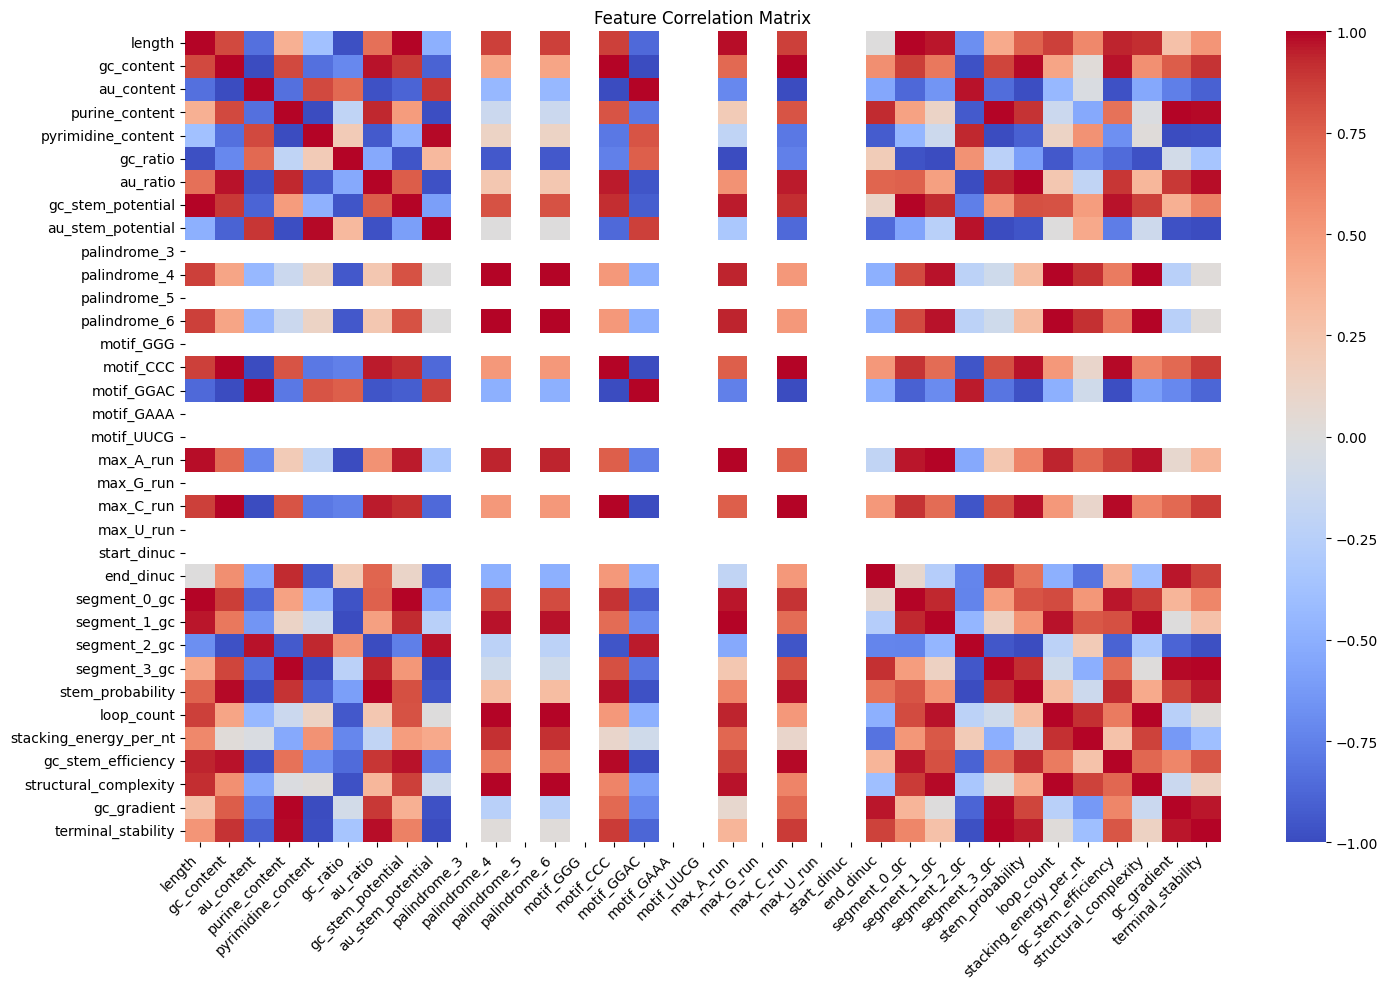


=== Feature Importance for mean_x ===


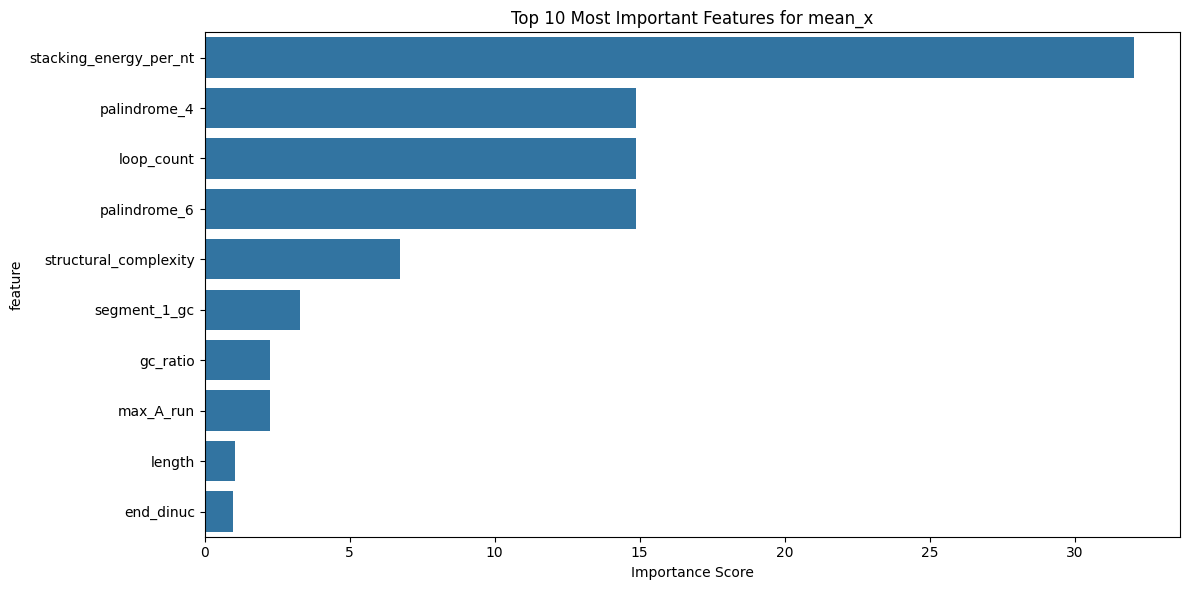


Top 10 Most Important Features for mean_x:
                   feature  importance_score
30  stacking_energy_per_nt         32.024822
10            palindrome_4         14.884446
29              loop_count         14.884446
12            palindrome_6         14.884446
32   structural_complexity          6.730289
25            segment_1_gc          3.290665
5                 gc_ratio          2.258912
18               max_A_run          2.258909
0                   length          1.033269
23               end_dinuc          0.967802

=== Feature Importance for mean_y ===


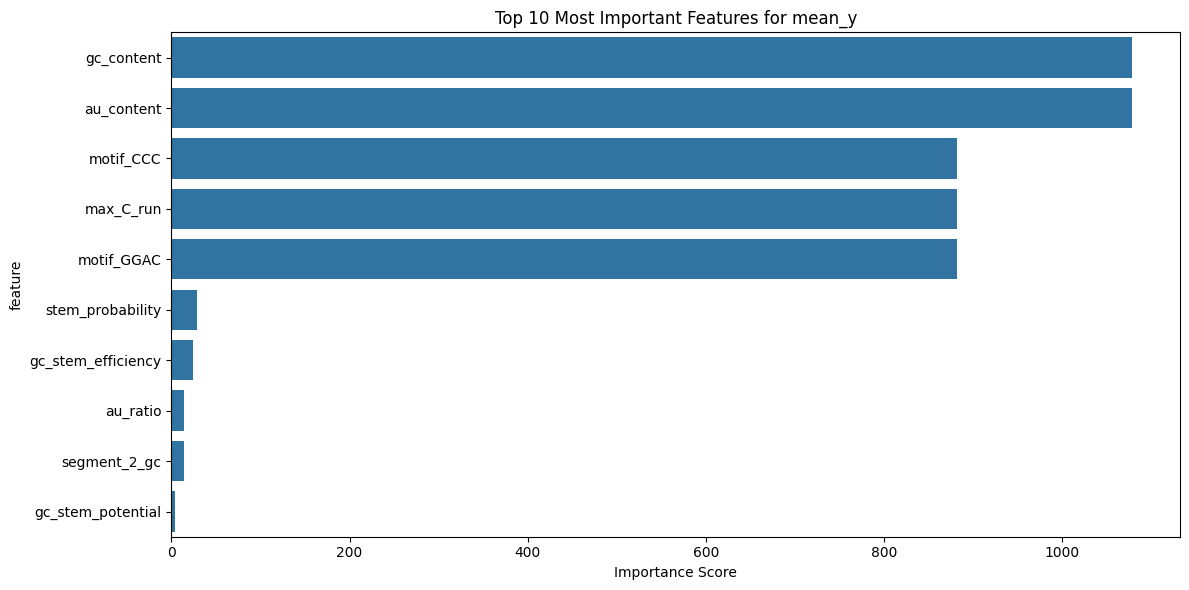


Top 10 Most Important Features for mean_y:
               feature  importance_score
1           gc_content       1078.343845
2           au_content       1078.343845
14           motif_CCC        881.498432
20           max_C_run        881.498432
15          motif_GGAC        881.498432
28    stem_probability         28.789073
31  gc_stem_efficiency         23.692980
6             au_ratio         14.533545
26        segment_2_gc         13.798737
7    gc_stem_potential          4.458352

=== Feature Importance for mean_z ===


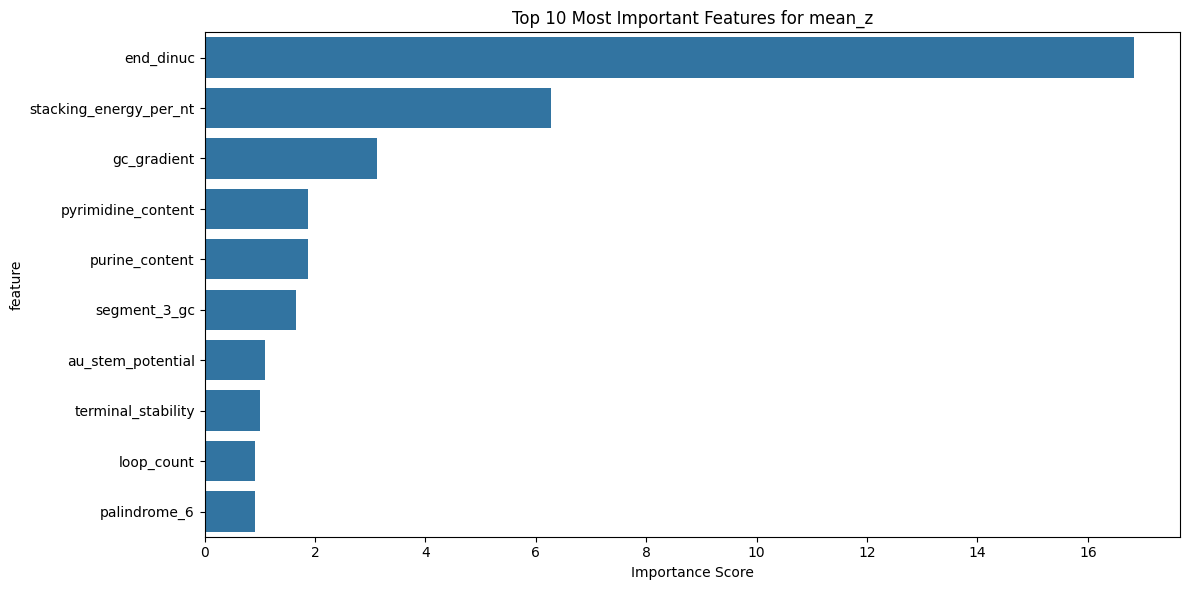


Top 10 Most Important Features for mean_z:
                   feature  importance_score
23               end_dinuc         16.827333
30  stacking_energy_per_nt          6.284284
33             gc_gradient          3.119841
4       pyrimidine_content          1.873832
3           purine_content          1.873832
27            segment_3_gc          1.663947
8        au_stem_potential          1.095024
34      terminal_stability          1.005239
29              loop_count          0.913222
12            palindrome_6          0.913222

=== Processed Feature Values ===
   length  gc_content  au_content  purine_content  pyrimidine_content  \
0      29       0.655       0.345           0.586               0.414   
1      34       0.647       0.353           0.559               0.441   
2      24       0.542       0.458           0.542               0.458   

   gc_ratio  au_ratio  gc_stem_potential  au_stem_potential  palindrome_3  \
0     1.111     2.333                  9                 

In [17]:
# Feature Analysis and Selection
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns

def analyze_feature_importance(sequences_df, coordinates_df):
    # First, ensure we have matching sequences and coordinates
    sequence_ids = sequences_df['target_id'].tolist()
    
    # Modified coordinate matching: strip the numeric suffix from coordinate IDs
    coordinates_df['base_ID'] = coordinates_df['ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    valid_coords = coordinates_df[coordinates_df['base_ID'].isin(sequence_ids)]
    
    if len(valid_coords) == 0:
        print("No matching coordinates found for sequences!")
        return None, None
        
    # Create feature matrix
    feature_extractor = FinalRNAFeatureExtractor()
    features_list = []
    valid_targets = []
    
    print("Extracting final feature set...")
    for idx, row in sequences_df.iterrows():
        seq = row['sequence']
        seq_id = row['target_id']
        
        # Get corresponding coordinates using base_ID
        seq_coords = valid_coords[valid_coords['base_ID'] == seq_id]
        if len(seq_coords) > 0:
            features = feature_extractor.extract_features(seq)
            features_list.append(features)
            # Use mean coordinates as target
            valid_targets.append({
                'mean_x': seq_coords['x_1'].mean(),
                'mean_y': seq_coords['y_1'].mean(),
                'mean_z': seq_coords['z_1'].mean()
            })
    
    if not features_list:
        print("No valid feature-coordinate pairs found!")
        return None, None
        
    features_df = pd.DataFrame(features_list)
    targets_df = pd.DataFrame(valid_targets)
    
    print(f"\nProcessed {len(features_list)} sequences with matching coordinates")
    print(f"Each sequence has {len(valid_coords) // len(sequence_ids)} coordinate points on average")
    
    # Separate numeric and categorical columns
    numeric_columns = features_df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = features_df.select_dtypes(include=['object']).columns
    
    # Handle categorical features
    if len(categorical_columns) > 0:
        print("\nEncoding categorical features...")
        label_encoders = {}
        for col in categorical_columns:
            label_encoders[col] = LabelEncoder()
            features_df[col] = label_encoders[col].fit_transform(features_df[col])
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)
    features_scaled = pd.DataFrame(features_scaled, columns=features_df.columns)
    
    # Print feature summary
    print("\n=== Feature Summary ===")
    print(f"Total features: {len(features_df.columns)}")
    print(f"Numeric features: {len(numeric_columns)}")
    print(f"Categorical features (encoded): {len(categorical_columns)}")
    
    # Correlation analysis
    plt.figure(figsize=(15, 10))
    sns.heatmap(features_scaled.corr(), cmap='coolwarm', center=0, annot=False)
    plt.title('Feature Correlation Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Feature importance for each coordinate
    for coord in ['mean_x', 'mean_y', 'mean_z']:
        print(f"\n=== Feature Importance for {coord} ===")
        selector = SelectKBest(f_regression, k=min(10, len(features_df.columns)))
        selector.fit(features_scaled, targets_df[coord])
        
        # Get feature importance scores
        importance_df = pd.DataFrame({
            'feature': features_df.columns,
            'importance_score': selector.scores_
        })
        importance_df = importance_df.sort_values('importance_score', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        sns.barplot(data=importance_df.head(10), x='importance_score', y='feature')
        plt.title(f'Top 10 Most Important Features for {coord}')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 10 Most Important Features for {coord}:")
        print(importance_df.head(10))
    
    return importance_df, features_df

# Run the analysis on our test sequences
print("Loading test data...")
test_sequences = train_sequences.head(3)
print("\nTest sequences:")
print(test_sequences[['target_id', 'sequence']])

test_coordinates = train_labels[train_labels['ID'].str.split('_').str[:-1].str.join('_').isin(test_sequences['target_id'])]
print("\nMatching coordinates shape:", test_coordinates.shape)

print("\nRunning feature importance analysis...")
importance_results, processed_features = analyze_feature_importance(test_sequences, test_coordinates)

if processed_features is not None:
    print("\n=== Processed Feature Values ===")
    print(processed_features.round(3))

### findings con'td:

**coordinate-specific important features:**

  - **for x-coordinates (width):**
    - stacking energy per nucleotide is most important (32.02)  
    - structural features (palindromes, loops) are next most important  
    - length and end dinucleotides have less impact  

  - **for y-coordinates (depth):**
    - base composition (GC/AU content) dominates (1078.34)  
    - specific motifs (CCC, GGAC) are highly important (881.50)  
    - stem-related features have moderate importance  

  - **for z-coordinates (height):**
    - end dinucleotides are most important (16.83)  
    - stacking energy and GC gradient follow  
    - mix of structural and compositional features  

**feature correlations (from heatmap):**

  - **strong positive correlation between:**
    - GC content and motif_CCC/max_C_run  
    - structural complexity and stacking energy  
    - segment GC contents with overall GC content  

  - **strong negative correlation between:**
    - AU content and GC content (expected)  
    - purine and pyrimidine content  
    - terminal features and internal features  
